In [1]:
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf

from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_embedding_weights(text_dir, filename):
    """Loads the word embedding weights from a pre-trained model.
    
    Parameters:
        text_dir: The directory containing the text file with the weights.
        filename: The name of that text file.
        
    Returns:
        vocabulary: A list containing the words in the vocabulary.
        embedding: A numpy array of the weights.
    """
    vocabulary = []
    embedding = []
    with open(os.path.join(text_dir, filename), 'rb') as f:
        for line in f.readlines():
            row = line.strip().split(' ')
            vocabulary.append(row[0])
            embedding.append(map(np.float32, row[1:]))
        embedding = np.array(embedding)
        print('Finished loading word embedding weights.')
    return vocabulary, embedding

text_dir = 'text_model/embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = load_embedding_weights(text_dir, filename)
vocab_size, embedding_dim = embedding.shape
word_to_id = dict(zip(vocabulary, range(vocab_size)))

# Unknown words vector with zeros
embedding = np.concatenate([embedding, np.zeros((1, embedding_dim))])

Finished loading word embedding weights.


In [3]:
# Convert a string representation of a list such as '[happy, sun, outdoors]'
# to a set of strings {'happy', 'sun', 'outdoors'}
def str_list_to_set(str_list):
    output = str_list[1:-1].split(',')
    output = set([x.strip() for x in output])
    return output

def hashtag_in_post(df, tag):
    # Make sure that the relevant hashtag is in the post
    df['tags'] = df['tags'].map(str_list_to_set)
    mask = df['tags'].map(lambda x: tag in x)
    return df.loc[mask, :].reset_index(drop=True)

emotions = ['happy', 'sad', 'angry', 'scared', 'disgusted', 'surprised']
columns = [u'id', u'post_url', u'type', u'timestamp', u'date', u'tags', u'liked',
           u'note_count', u'photo', u'text', u'search_query']
df_all = pd.DataFrame(columns=columns)
for emotion in emotions:
    path = os.path.join('data', emotion + '.csv')
    df_emotion = hashtag_in_post(pd.read_csv(path, encoding='utf-8'), emotion)
    df_all = pd.concat([df_all, df_emotion]).reset_index(drop=True)

In [4]:
_PUNCTUATION = '!"$%&\'()*+,./:;<=>?[\\]^_`{|}~' # string.punctuation with hashtag removed

def paragraph_to_ids(paragraph, word_to_id, post_size):
    # Check for nan text
    words = []
    vocab_size = len(word_to_id)
    if (type(paragraph) == float) and (np.isnan(paragraph)):
        pass
    else:
        regex = re.compile('[%s]' % re.escape(_PUNCTUATION))
        # Remove punctuation, convert to lower case before splitting
        words = regex.sub('', paragraph).lower().split()
        # Replace unknown words by an id equal to the size of the vocab
        words = map(lambda x: word_to_id.get(x, vocab_size), words)
        
    if len(words) > post_size:
        words = words[:post_size]
    else:
        words = words + [vocab_size] * (post_size - len(words))
    return words

def create_text(X, word_to_id, post_size):
    train = X.copy()
    train['text_list'] = train['text'].map(lambda x: paragraph_to_ids(x, word_to_id, post_size))
    mask = train['text_list'].map(len) > 0
    train_reduced = train.loc[mask, :].reset_index(drop=True)
    return train_reduced

In [6]:
post_size = 100
train = create_text(df_all, word_to_id, post_size)

# Binarise emotions
emotion_dict = dict(zip(['happy', 'sad'], [1, 0]))
train['search_query'] =  train['search_query'].map(emotion_dict)
word_to_id['<ukn>'] = vocab_size

/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:14: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [7]:
#train_data, valid_data, test_data, word_to_id = ptb_raw_data('data')
id_to_word = {i: k for k, i in word_to_id.iteritems()}
vocab_size = len(word_to_id)
#hidden_size = 200
batch_size = 64
nb_emotions = 2
#num_layers = 2 # Number of stacked LSTMs
dropout = 1.0 # Proba to keep neurons
max_grad_norm = 5.0 # Maximum norm of gradient
init_scale = 0.1 # Weights initialization scale
initial_lr = 1e-2
lr_decay = 0.5
max_epoch_no_decay = 4 # Number of epochs not decaying learning rate
nb_epochs = 10 # Maximum number of epochs

In [8]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.int32, [None, post_size])
target = tf.placeholder(tf.int32, [None])
learning_rate = tf.Variable(initial_lr, trainable=False)
# Use a placeholder to turn off dropout during testing 
keep_prob = tf.placeholder(tf.float32)
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
def build_graph():
    # Word embedding
    W_embedding = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                              trainable=False, name='W_embedding')
    embedding_init = W_embedding.assign(embedding_placeholder)
    input_embed = tf.nn.embedding_lookup(W_embedding, input_data)
    input_embed_dropout = tf.nn.dropout(input_embed, keep_prob)
    
    # Rescale the mean by the actual number of non-zero values.
    nb_finite = tf.reduce_sum(tf.cast(tf.not_equal(input_embed_dropout, 0.0), tf.float32), axis=1)
    # If a post has zero finite elements, replace nb_finite by 1
    nb_finite = tf.where(tf.equal(nb_finite, 0.0), tf.ones_like(nb_finite), nb_finite)
    h1 = tf.reduce_mean(input_embed_dropout, axis=1) #* post_size / nb_finite
    W_softmax = tf.get_variable('W_softmax', [embedding_dim, nb_emotions])
    b_softmax = tf.get_variable('b_softmax', [nb_emotions])
    logits = tf.matmul(h1, W_softmax) + b_softmax
    #logits = tf.reshape(logits, [batch_size, num_steps, vocab_size])
    # Use sequence loss for average over batch and sum across timesteps
    #loss_vector = tf.contrib.seq2seq.sequence_loss(logits, target, weights=tf.ones([batch_size, num_steps]),
     #                                              average_across_batch=True, average_across_timesteps=False)
    
    labels = tf.one_hot(target, nb_emotions)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    # Use gradient cliping
    trainable_vars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), max_grad_norm)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.apply_gradients(zip(grads, trainable_vars),
                                           global_step=tf.contrib.framework.get_or_create_global_step())

    correct_pred = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), target)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return embedding_init, loss, accuracy, train_step

In [9]:
def run_model(sess, X, y, is_training, lr_decay=0.5, nb_epochs=1, show_loss_graph=True):
    batch_len = X.shape[0] / batch_size
    epoch_size = batch_len
    if is_training:
        # Iteration to print at
        print_iter = list(np.linspace(0, epoch_size - 1, 11).astype(int))
        initializer = tf.random_uniform_initializer(-init_scale, init_scale)    
        with tf.variable_scope('Model', reuse=None, initializer=initializer):
            embedding_init, loss, accuracy, train_step = build_graph()
        sess.run(tf.global_variables_initializer())
        sess.run(embedding_init, feed_dict={embedding_placeholder: embedding})
        # Dropout parameter
        dropout_param = dropout
        ops = [loss, accuracy, train_step]
    else:
        with tf.variable_scope('Model', reuse=True):
            initial_state, final_state, loss, accuracy, train_step = build_graph()
        dropout_param = 1.0
        ops = [final_state, loss, accuracy, tf.no_op()]

    for e in range(nb_epochs):
        print ('Epoch: {0}'.format(e + 1))
        X, y = shuffling(X, y)
        X = X[: batch_len * batch_size, :].reshape((batch_size, batch_len, -1))
        y = y[: batch_len * batch_size].reshape((batch_size, batch_len))
        lr_decay = lr_decay ** max(e + 1 - max_epoch_no_decay, 0)
        sess.run(tf.assign(learning_rate, initial_lr * lr_decay))

        total_loss = 0.0
        total_accuracy = 0.0
        nb_iter = 0.0
        loss_history = []
        t0 = time()
        for i in range(epoch_size):
            curr_input = X[:, i, :]
            curr_target = y[:, i]
            curr_loss, curr_acc, _ = sess.run(ops,
                                              feed_dict={input_data: curr_input, 
                                                         target: curr_target,
                                                         keep_prob: dropout_param})
            total_loss += curr_loss
            total_accuracy += curr_acc
            nb_iter += 1
            loss_history.append(curr_loss)
            
            if (is_training and i in print_iter):
                print('{0:.0f}% perplexity = {1:.3f}, accuracy = {2:.3f}, speed = {3:.0f} wps'\
                      .format(print_iter.index(i) * 10, 
                              total_loss / nb_iter, total_accuracy / (i + 1),
                              (nb_iter * batch_size) / (time() - t0)))
                
        if not is_training:
            print('Perplexity = {0:.3f}, accuracy = {1:.3f}, speed = {2:.0f} wps'\
                  .format(total_loss / nb_iter, total_accuracy / (i + 1),
                          (nb_iter * batch_size) / (time() - t0)))

        if (is_training and show_loss_graph):
            plt.plot(loss_history)
            plt.grid(True)
            plt.title('Epoch {0}'.format(e + 1))
            plt.xlabel('Mini-batch number')
            plt.ylabel('Perplexity per mini-batch')
            plt.show()

In [10]:
X_train = np.stack(train['text_list'])
y_train = train['search_query'].values

def shuffling(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

Training:
Epoch: 1
0% perplexity = 0.402, accuracy = 0.266, speed = 3516 wps
10% perplexity = 0.387, accuracy = 0.365, speed = 15691 wps
20% perplexity = 0.382, accuracy = 0.377, speed = 15770 wps
30% perplexity = 0.378, accuracy = 0.379, speed = 15847 wps
40% perplexity = 0.376, accuracy = 0.381, speed = 15845 wps
50% perplexity = 0.374, accuracy = 0.383, speed = 15856 wps
60% perplexity = 0.372, accuracy = 0.384, speed = 15838 wps
70% perplexity = 0.371, accuracy = 0.385, speed = 15279 wps
80% perplexity = 0.370, accuracy = 0.385, speed = 15147 wps
90% perplexity = 0.369, accuracy = 0.386, speed = 14928 wps
100% perplexity = 0.368, accuracy = 0.386, speed = 14858 wps


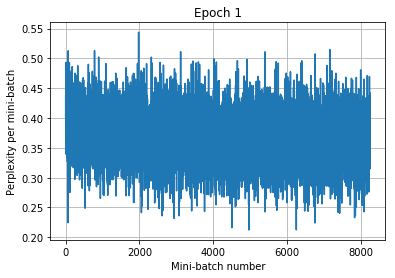

Epoch: 2
0% perplexity = 0.396, accuracy = 0.297, speed = 1740 wps
10% perplexity = 0.360, accuracy = 0.389, speed = 11839 wps
20% perplexity = 0.359, accuracy = 0.389, speed = 13193 wps
30% perplexity = 0.359, accuracy = 0.388, speed = 13246 wps
40% perplexity = 0.358, accuracy = 0.389, speed = 12606 wps
50% perplexity = 0.358, accuracy = 0.389, speed = 11990 wps
60% perplexity = 0.357, accuracy = 0.388, speed = 11277 wps
70% perplexity = 0.356, accuracy = 0.388, speed = 11029 wps
80% perplexity = 0.356, accuracy = 0.388, speed = 10919 wps
90% perplexity = 0.356, accuracy = 0.388, speed = 11001 wps
100% perplexity = 0.356, accuracy = 0.388, speed = 11055 wps


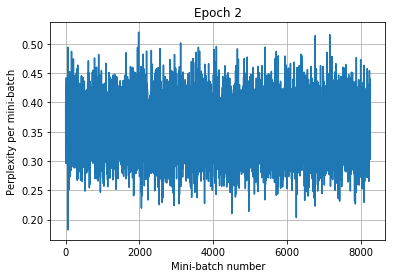

Epoch: 3
0% perplexity = 0.415, accuracy = 0.266, speed = 1314 wps
10% perplexity = 0.355, accuracy = 0.388, speed = 11274 wps
20% perplexity = 0.354, accuracy = 0.387, speed = 11213 wps
30% perplexity = 0.354, accuracy = 0.386, speed = 11404 wps
40% perplexity = 0.353, accuracy = 0.387, speed = 11623 wps
50% perplexity = 0.353, accuracy = 0.387, speed = 11755 wps
60% perplexity = 0.352, accuracy = 0.387, speed = 12311 wps
70% perplexity = 0.352, accuracy = 0.386, speed = 12713 wps
80% perplexity = 0.352, accuracy = 0.386, speed = 13010 wps
90% perplexity = 0.352, accuracy = 0.386, speed = 13236 wps
100% perplexity = 0.352, accuracy = 0.386, speed = 13473 wps


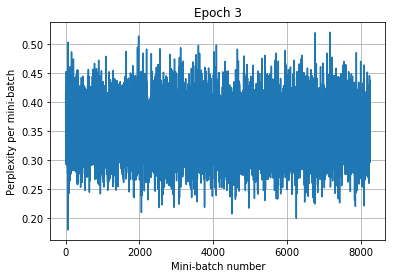

Epoch: 4
0% perplexity = 0.431, accuracy = 0.281, speed = 1943 wps
10% perplexity = 0.353, accuracy = 0.386, speed = 15765 wps
20% perplexity = 0.352, accuracy = 0.386, speed = 15320 wps
30% perplexity = 0.352, accuracy = 0.385, speed = 13326 wps
40% perplexity = 0.351, accuracy = 0.385, speed = 12473 wps
50% perplexity = 0.351, accuracy = 0.386, speed = 12129 wps
60% perplexity = 0.351, accuracy = 0.385, speed = 12379 wps
70% perplexity = 0.351, accuracy = 0.385, speed = 12814 wps
80% perplexity = 0.351, accuracy = 0.385, speed = 13207 wps
90% perplexity = 0.351, accuracy = 0.385, speed = 13394 wps
100% perplexity = 0.351, accuracy = 0.385, speed = 13545 wps


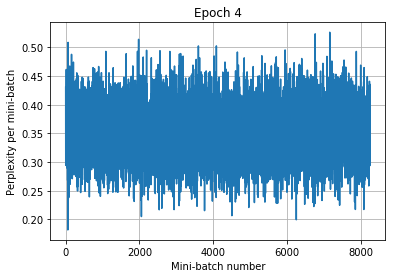

Epoch: 5
0% perplexity = 0.441, accuracy = 0.266, speed = 1588 wps
10% perplexity = 0.352, accuracy = 0.385, speed = 15193 wps
20% perplexity = 0.351, accuracy = 0.385, speed = 15903 wps
30% perplexity = 0.351, accuracy = 0.384, speed = 16177 wps
40% perplexity = 0.351, accuracy = 0.384, speed = 16084 wps
50% perplexity = 0.351, accuracy = 0.385, speed = 15972 wps
60% perplexity = 0.350, accuracy = 0.384, speed = 15911 wps
70% perplexity = 0.350, accuracy = 0.384, speed = 15995 wps
80% perplexity = 0.350, accuracy = 0.384, speed = 16025 wps
90% perplexity = 0.350, accuracy = 0.384, speed = 15891 wps
100% perplexity = 0.350, accuracy = 0.384, speed = 15780 wps


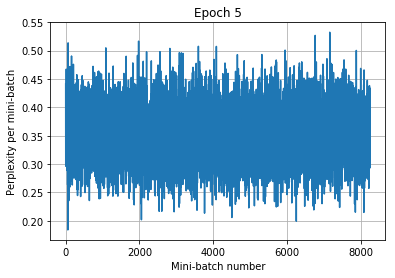

In [11]:
with tf.Session() as sess:
    print('Training:')
    run_model(sess, X_train, y_train, lr_decay=lr_decay, is_training=True, nb_epochs=5)
    #print('\nValidation:')
    #run_model(sess, valid_data, is_training=False, nb_epochs=1)

In [36]:
var1 = tf.placeholder(tf.float32, [2, 2, 3])
nb_finite = tf.reduce_sum(tf.cast(tf.not_equal(var1, 0.0), tf.float32), axis=1)
nb_finite = tf.where(tf.equal(nb_finite, 0.0), tf.ones_like(nb_finite), nb_finite)
mean_test = tf.reduce_mean(var1, axis=1)

np_arr = np.array([[[1, 0., 5.], [2, 0, 0.]], [[1, 0., 5.], [2, 2, 0.]]])

with tf.Session() as sess:
    print(sess.run(mean_test, feed_dict={var1: np_arr}))
    print(sess.run(mean_test * 2 / nb_finite, feed_dict={var1: np_arr}))
    print(sess.run(nb_finite, feed_dict={var1: np_arr}))

[[ 1.5  0.   2.5]
 [ 1.5  1.   2.5]]
[[ 1.5  0.   5. ]
 [ 1.5  2.   5. ]]
[[ 2.  1.  1.]
 [ 2.  1.  1.]]
